In [49]:
import pandas as pd
import numpy as np
import os, sys
import seaborn as sns

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from collections import Counter
#import cv2

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Dropout, LeakyReLU, BatchNormalization, Reshape
from keras import layers
from keras import models
from keras import optimizers

In [3]:
files=[]
types=[]
codes=[]

In [4]:
def createData(folder, i):
    for filename in os.listdir(folder):
        files.append(filename)
        types.append(folder)
        codes.append(i)

In [5]:
createData('Coast',0)
createData('Desert',1)
createData('Forest',2)
createData('Glacier',3)
createData('Mountain',4)

In [6]:
data = {
  "filename": files,
  "type": types,
  "code": codes,
}

data_array = pd.DataFrame(data)

In [7]:
data_array

,filename,type,code
0,Coast-Train (1).jpeg,Coast,0
1,Coast-Train (10).jpeg,Coast,0
2,Coast-Train (100).jpeg,Coast,0
3,Coast-Train (101).jpeg,Coast,0
4,Coast-Train (102).jpeg,Coast,0
...,...,...,...
2495,Mountain (4971).jpeg,Mountain,4
2496,Mountain (4972).jpeg,Mountain,4
2497,Mountain (4973).jpeg,Mountain,4
2498,Mountain (4974).jpeg,Mountain,4


In [8]:
types=['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']
examples=[]
for i in range(5):
    examples.append(data_array['filename'][i*500])

In [9]:
x = []
for i in range(len(examples)):
    path=types[i]+"/"+ examples[i]
    image = io.imread(path)
    image_res = resize(image, (100, 100), anti_aliasing=True)
    np_pic = np.array(image_res, dtype=np.float32)
    x.append(np_pic)

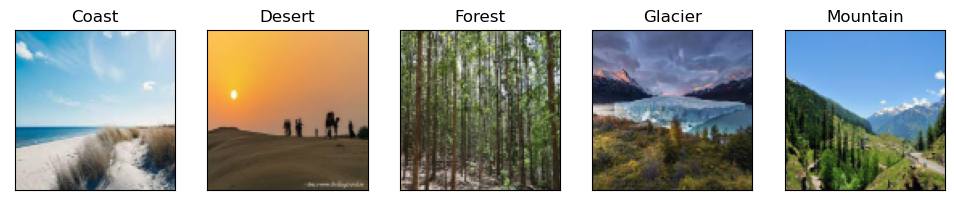

In [10]:
fig = plt.figure(figsize=(12,60))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.set_title(types[i])     
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x[i])

In [11]:
x = []
y=data_array['code']
for i in range(int(len(data_array['filename'])/5)):
    path=data_array['type'][i*5]+"/"+ data_array['filename'][i*5]
    image = io.imread(path)
    image_res = resize(image, (32, 32), anti_aliasing=True)
    np_pic = np.array(image_res, dtype=np.float32)
    x.append(np_pic)

In [12]:
np.save('landscape.npy', x)

In [13]:
x = np.load('landscape.npy')

In [14]:
x=np.asarray(x)

In [15]:
x.shape

(500, 32, 32, 3)

In [16]:
def discriminator():
    model = keras.Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

In [18]:
discr=discriminator()
discr.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 256)        

In [19]:
latent_dim = 100

In [33]:
def generator():
    model = keras.Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model 

In [34]:
gener = generator()

In [35]:
def build_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = keras.Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
    return model

In [41]:
gan = build_gan(gener, discr)

In [37]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise)
    # scale from [-1,1] to [0,1]
    generated_images = (generated_images + 1) / 2.0
    
    plt.figure(figsize=(20, 4))
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [50]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [51]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x.shape[0]/batch_size)
    for ep in range(epochs+1):
        with HiddenPrints():
            for i in range(num_batches):
                noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
                image_batch = x[np.random.randint(0, x.shape[0], size=batch_size)]
            
             # Generate fake images
                generated_images = gener.predict(noise)
            
                X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
                y_dis = np.zeros(2*batch_size)
                y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
                discr.trainable = True
                d_loss, _ = discr.train_on_batch(X, y_dis)
                discrim_losses.append(d_loss)

            # Train generator
                noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
                y_gen = np.ones(batch_size)
                discr.trainable = False
                gan.train_on_batch(noise, y_gen)
        if ep % 10 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, gener)
            tf.keras.backend.clear_session()  

epoch:  0
1/1 [==============================] - 2s 2s/step


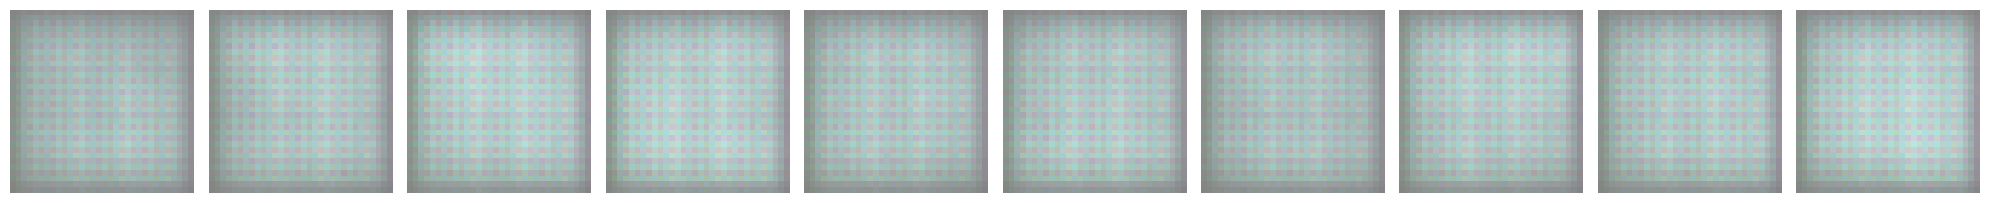

epoch:  10
1/1 [==============================] - 2s 2s/step


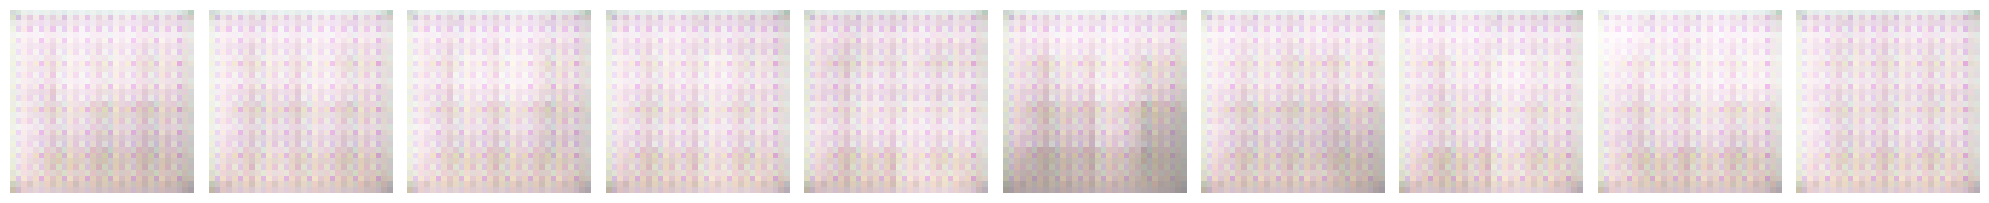

epoch:  20
1/1 [==============================] - 1s 1s/step


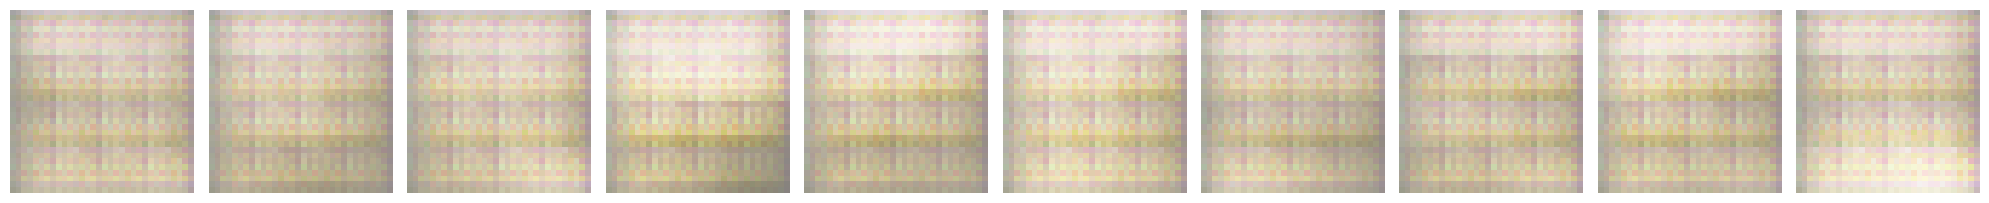

epoch:  30
1/1 [==============================] - 1s 1s/step


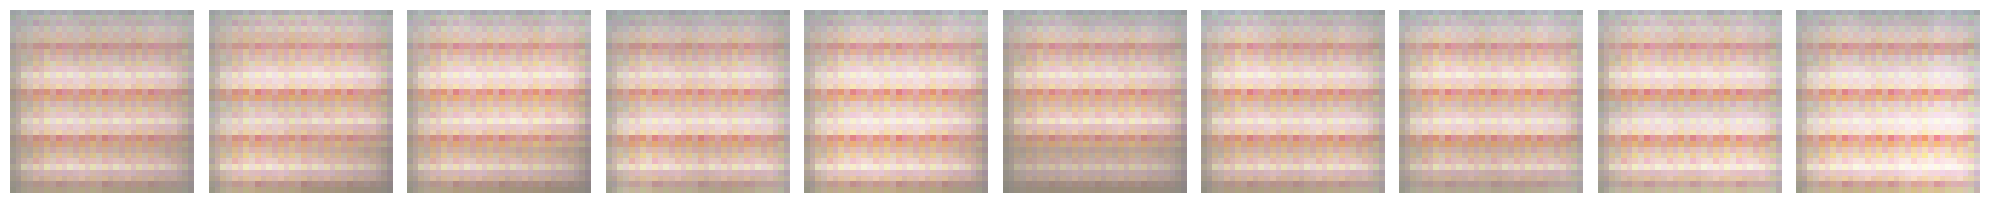

epoch:  40
1/1 [==============================] - 1s 1s/step


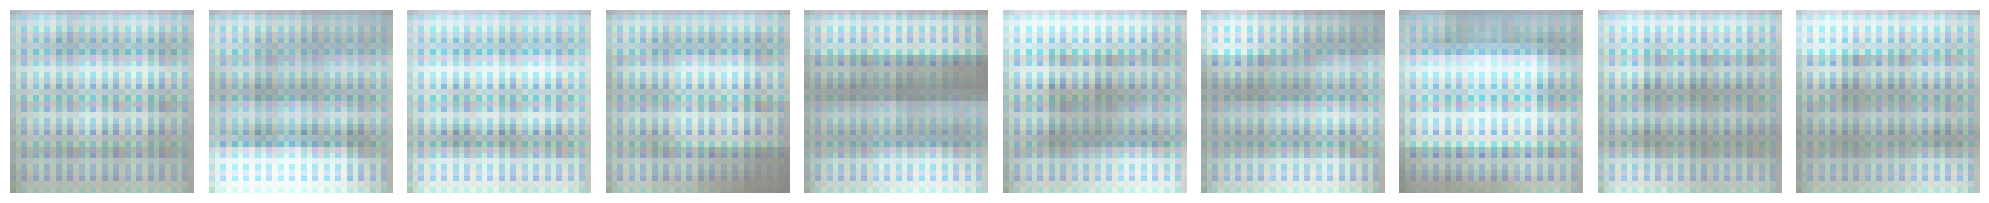

epoch:  50
1/1 [==============================] - 2s 2s/step


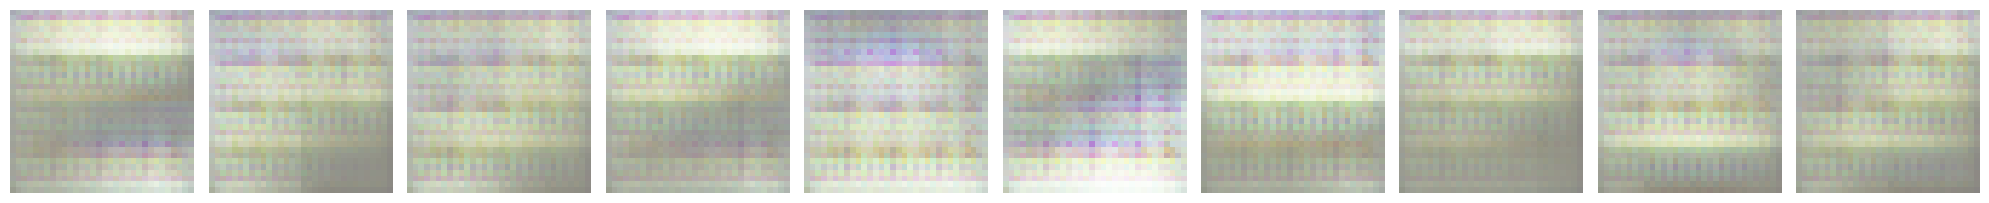

epoch:  60
1/1 [==============================] - 1s 1s/step


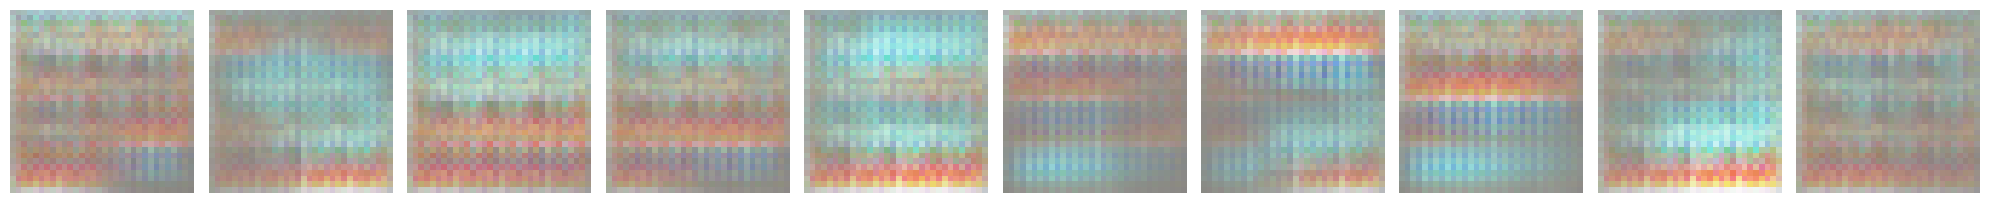

epoch:  70
1/1 [==============================] - 1s 1s/step


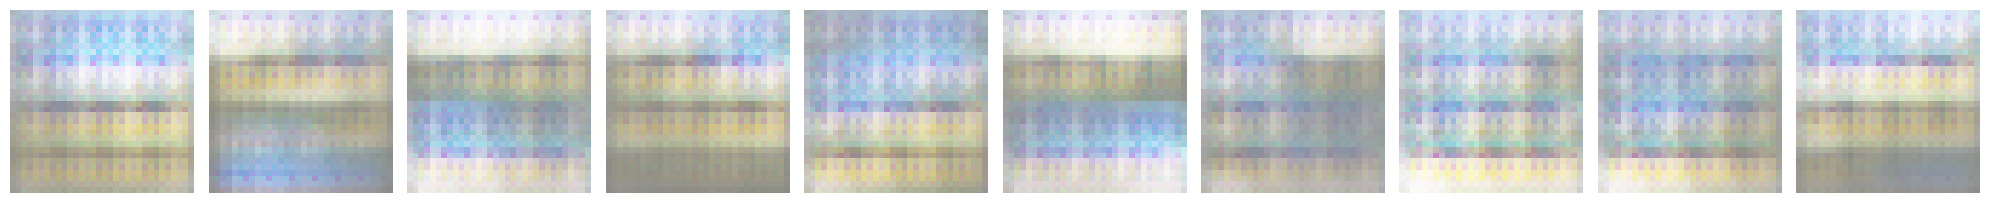

epoch:  80
1/1 [==============================] - 1s 1s/step


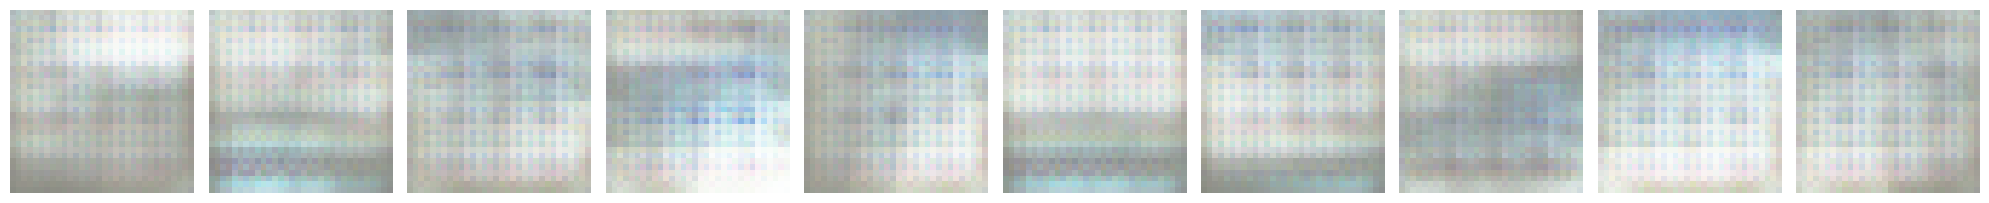

epoch:  90
1/1 [==============================] - 1s 1s/step


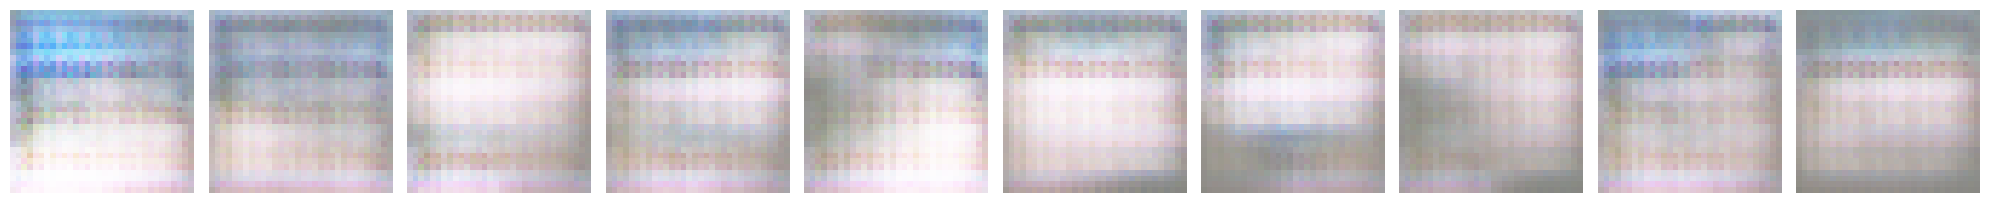

epoch:  100
1/1 [==============================] - 1s 1s/step


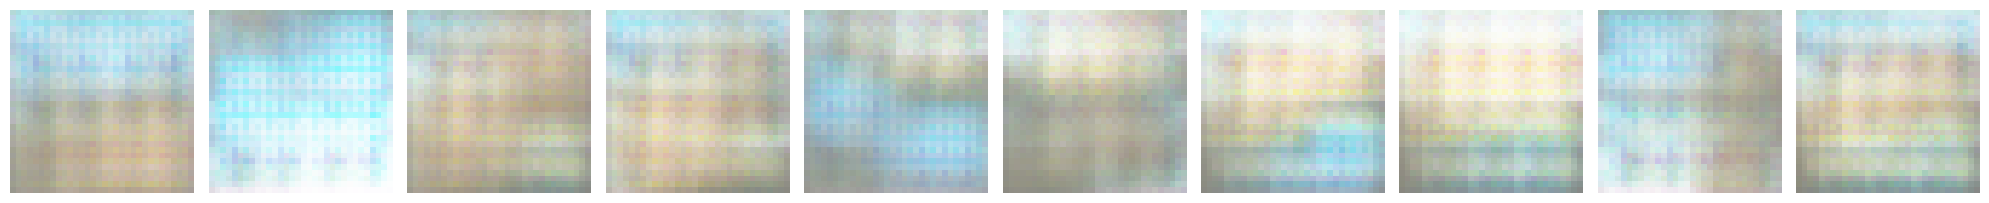

In [52]:
epochs = 100 # to get good quality images, you should train the model for more than 100 epochs
batch_size = 64
train_model(epochs, batch_size)

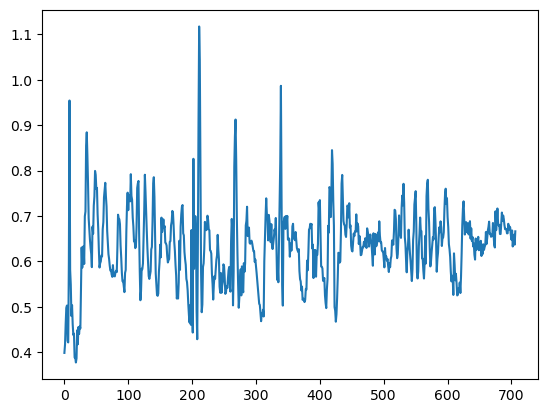

In [53]:
plt.plot(discrim_losses)

In [54]:
gan.save_weights("saved_model\\" + 'landmodel')

In [55]:
gan.load_weights("saved_model\\" + 'landmodel')

epoch:  0
1/1 [==============================] - 1s 1s/step


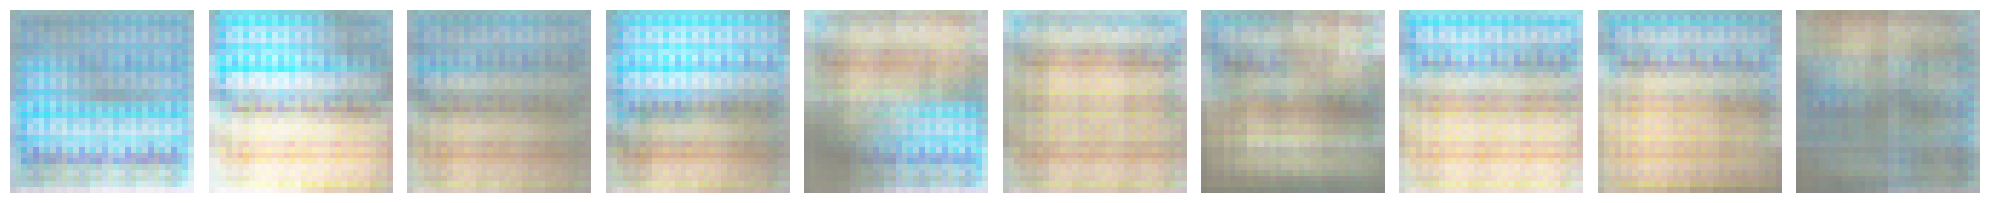

epoch:  10
1/1 [==============================] - 1s 1s/step


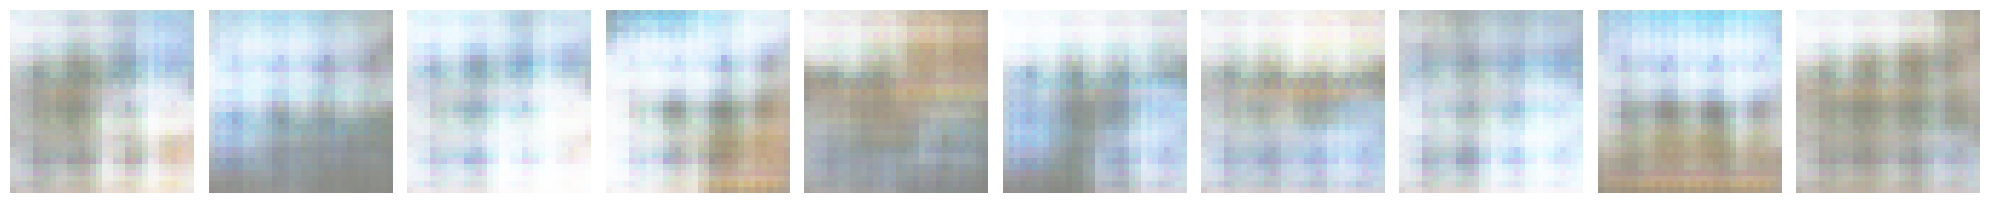

epoch:  20
1/1 [==============================] - 1s 1s/step


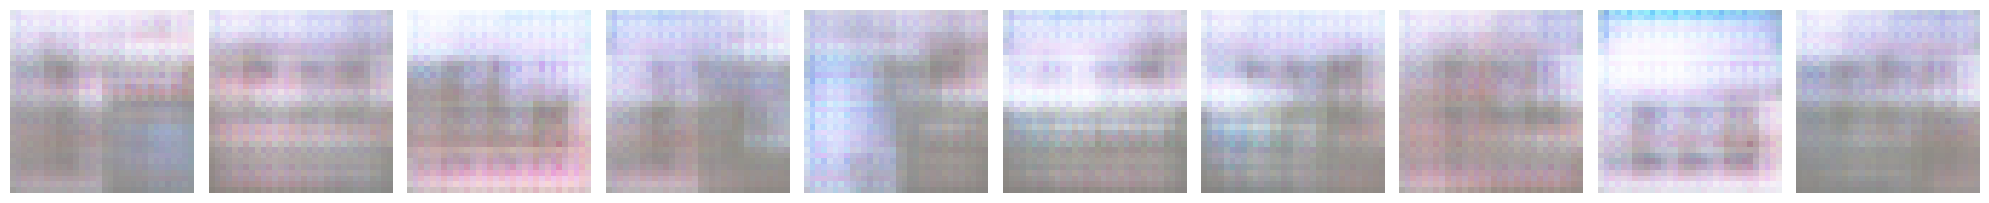

epoch:  30
1/1 [==============================] - 1s 1s/step


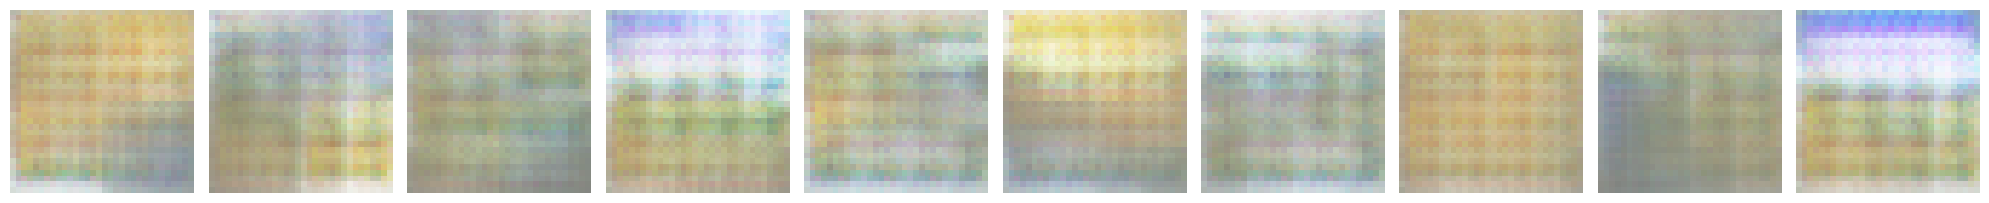

epoch:  40
1/1 [==============================] - 2s 2s/step


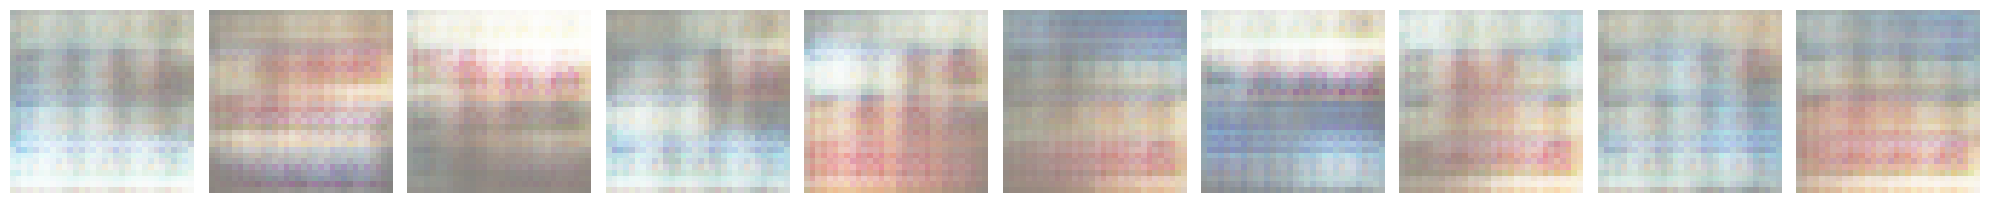

epoch:  50
1/1 [==============================] - 1s 1s/step


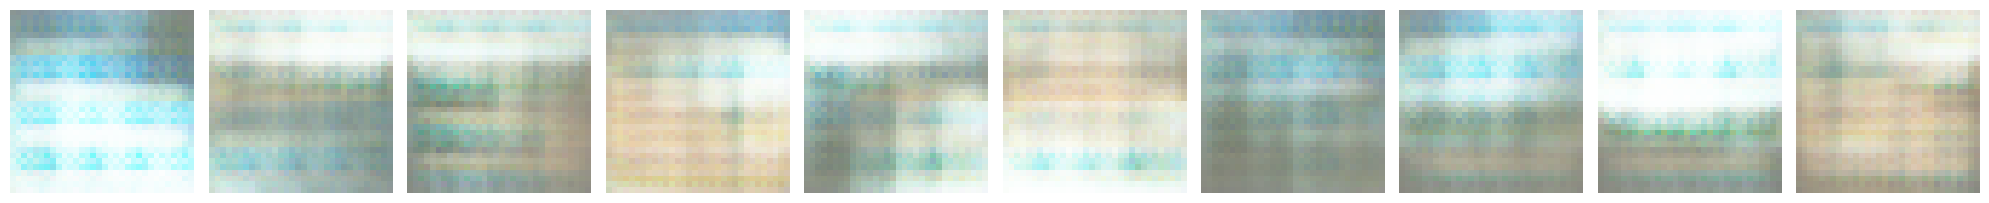

epoch:  60
1/1 [==============================] - 2s 2s/step


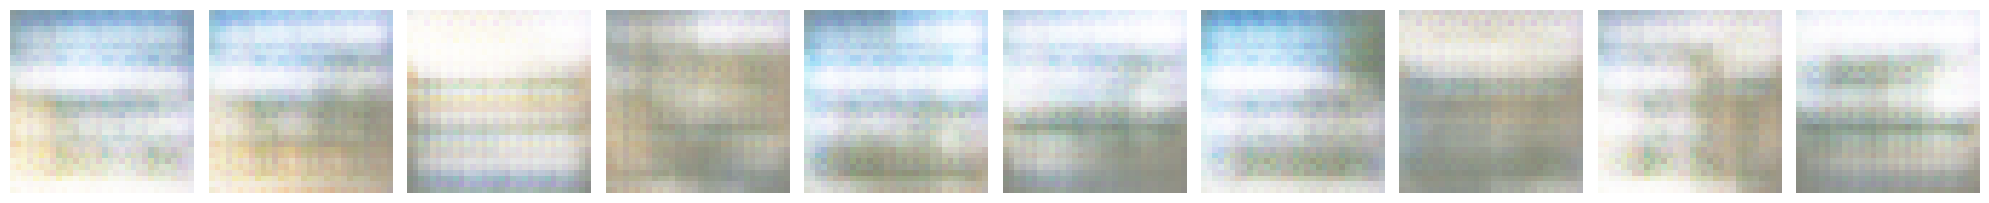

epoch:  70
1/1 [==============================] - 1s 1s/step


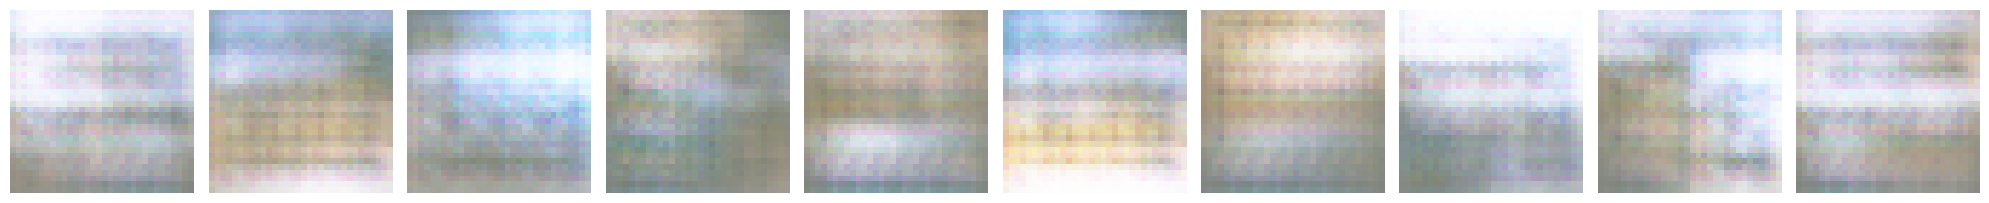

epoch:  80
1/1 [==============================] - 2s 2s/step


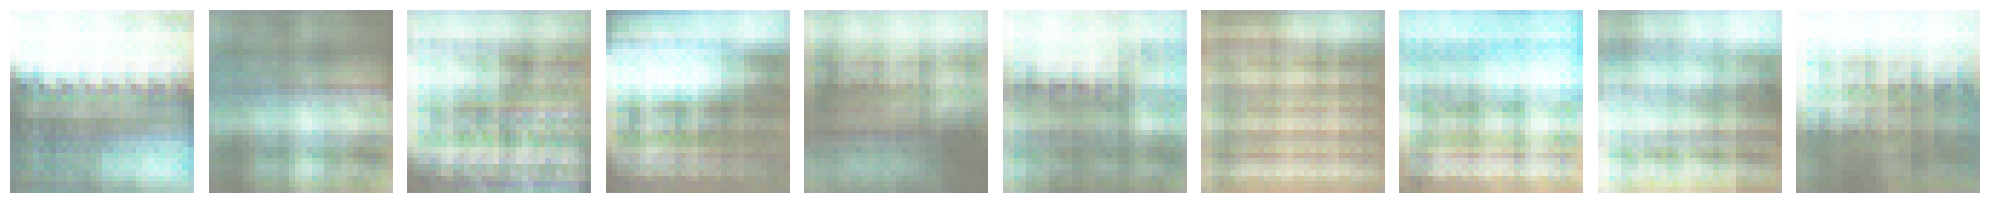

epoch:  90
1/1 [==============================] - 2s 2s/step


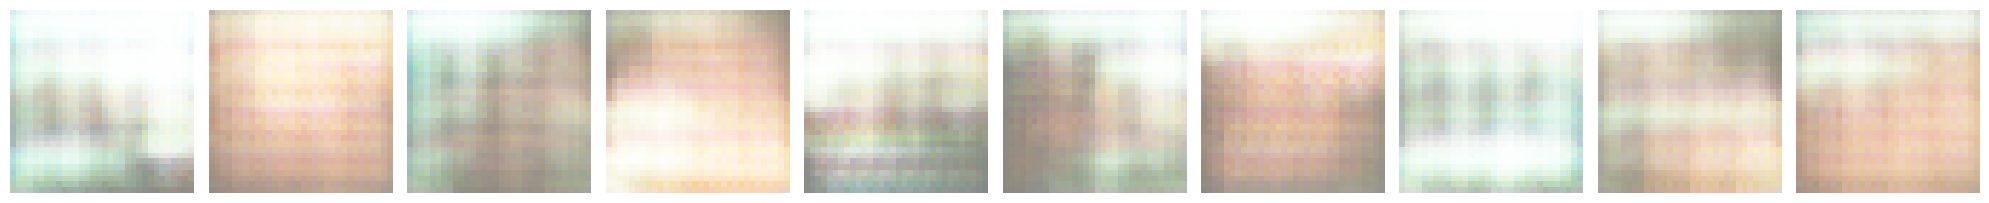

epoch:  100
1/1 [==============================] - 1s 1s/step


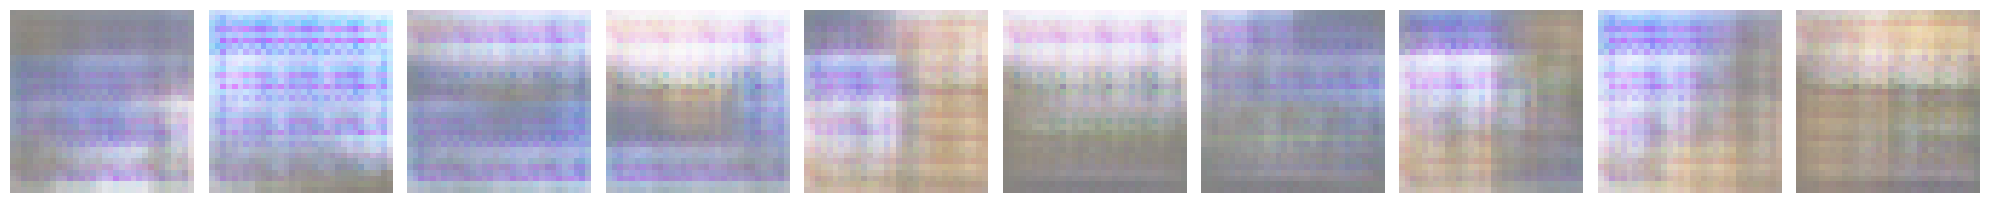

In [56]:
train_model(epochs, batch_size)

In [57]:
gan.save_weights("saved_model\\" + 'land2model')

In [58]:
gan.load_weights("saved_model\\" + 'land2model')

epoch:  0
1/1 [==============================] - 1s 1s/step


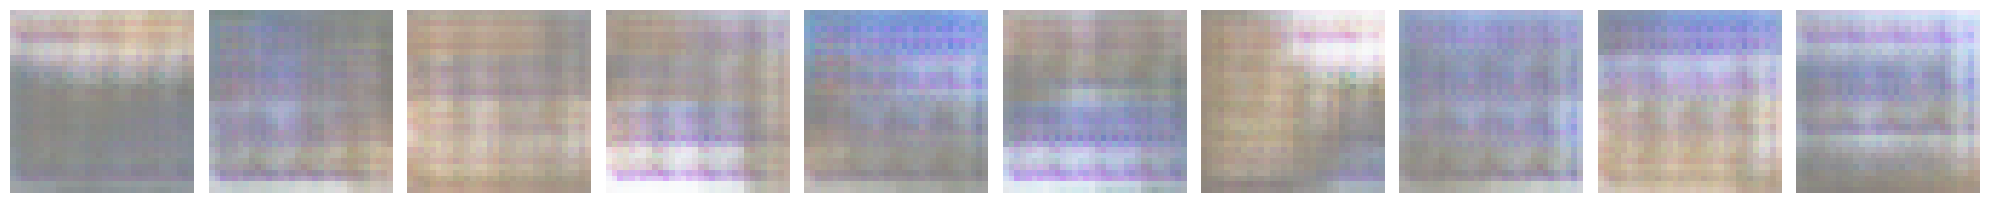

epoch:  10
1/1 [==============================] - 1s 1s/step


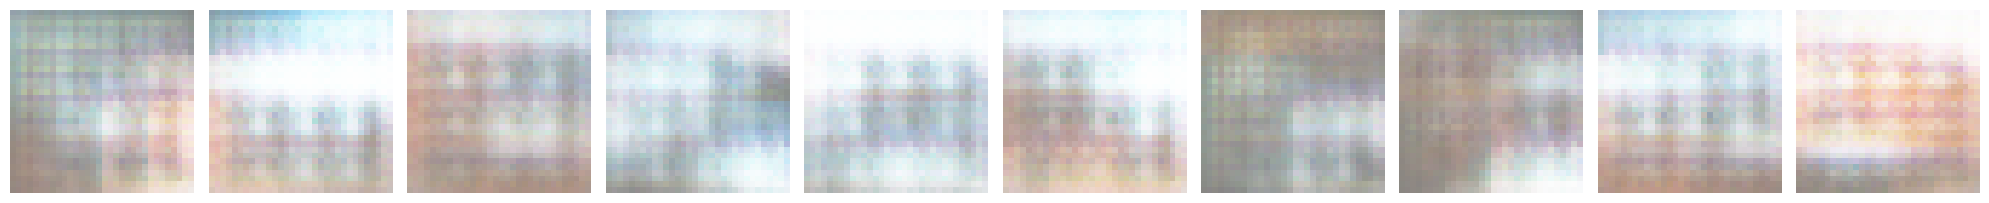

epoch:  20
1/1 [==============================] - 1s 1s/step


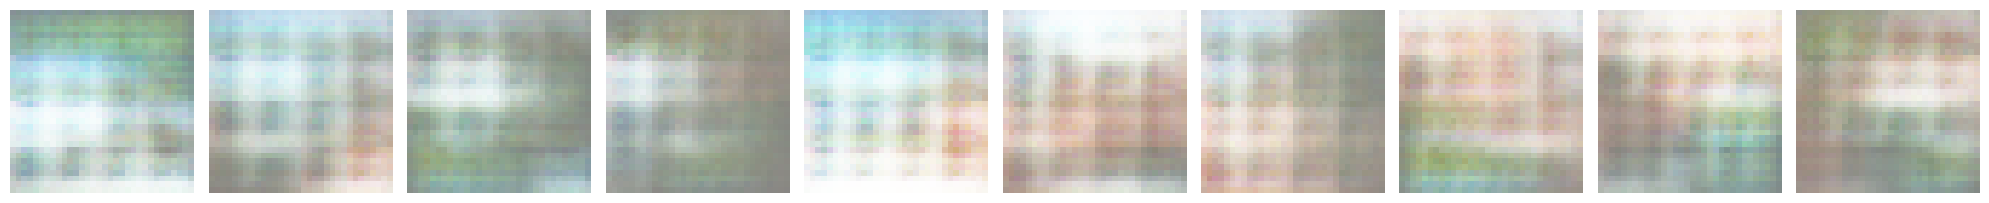

epoch:  30
1/1 [==============================] - 1s 1s/step


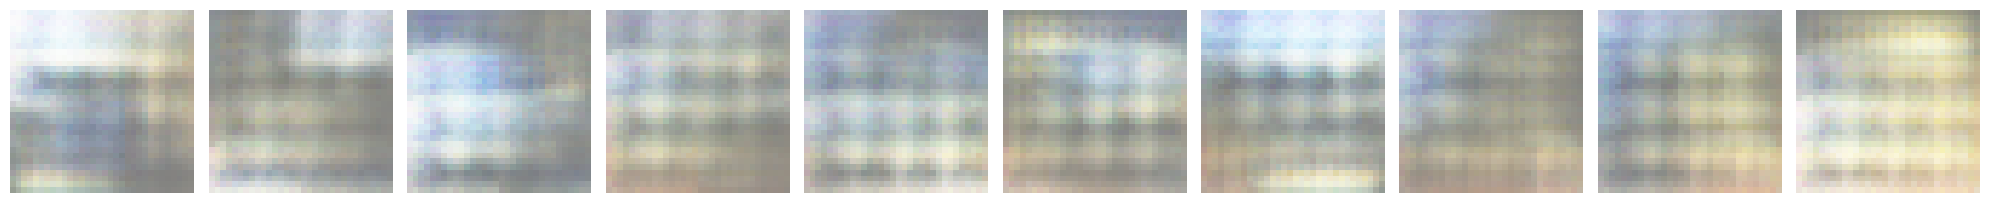

epoch:  40
1/1 [==============================] - 1s 1s/step


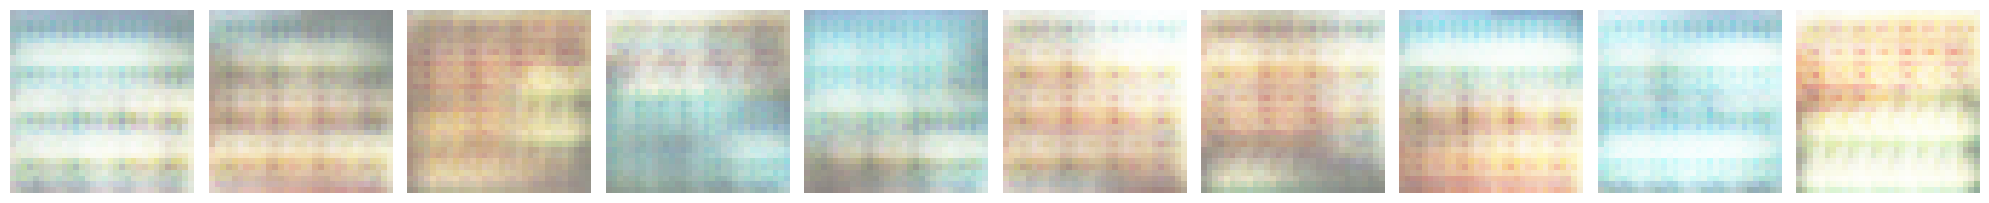

epoch:  50
1/1 [==============================] - 1s 1s/step


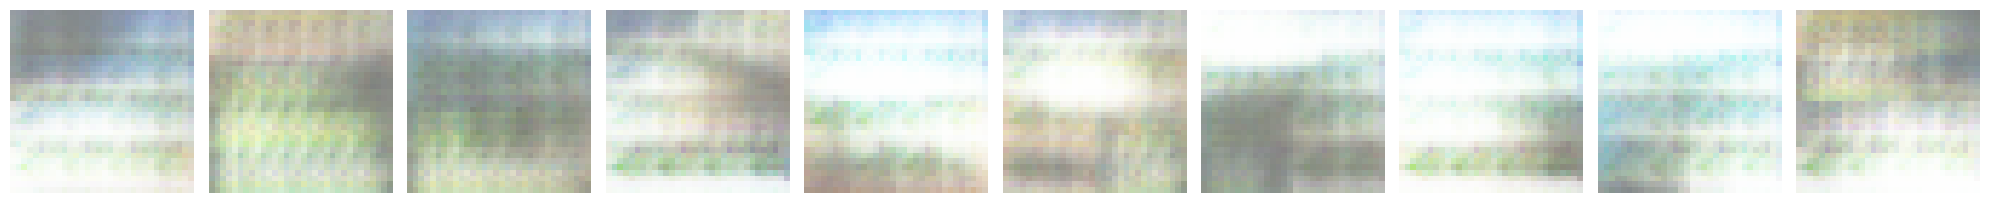

epoch:  60
1/1 [==============================] - 1s 1s/step


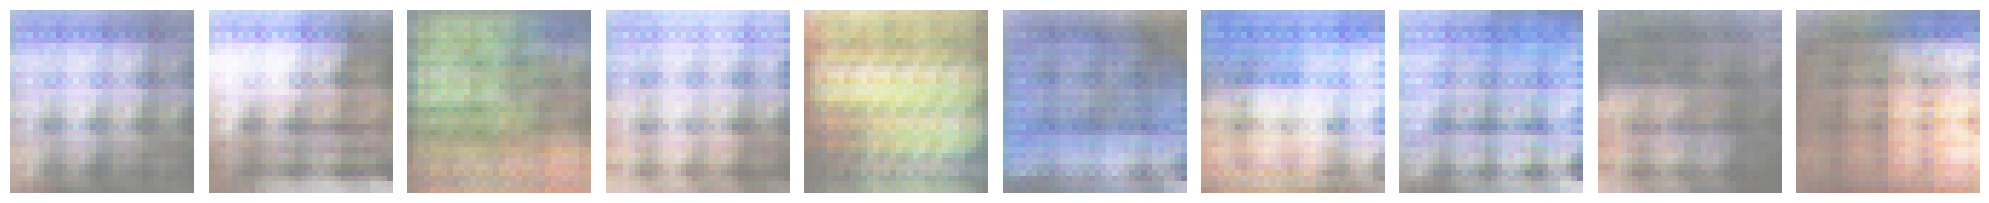

epoch:  70
1/1 [==============================] - 1s 1s/step


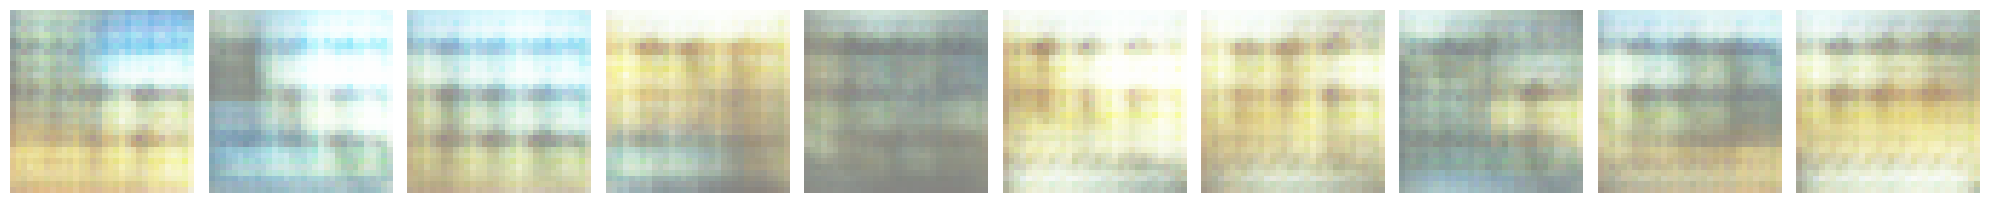

epoch:  80
1/1 [==============================] - 1s 1s/step


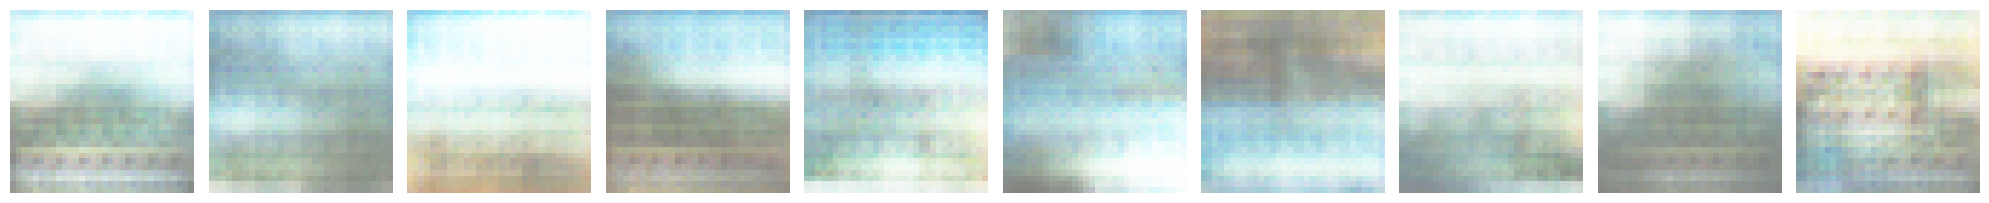

epoch:  90
1/1 [==============================] - 1s 1s/step


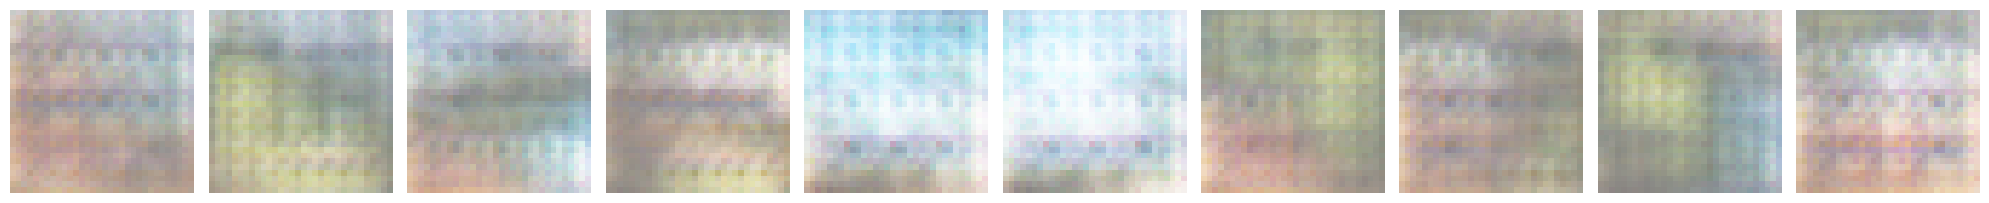

epoch:  100
1/1 [==============================] - 2s 2s/step


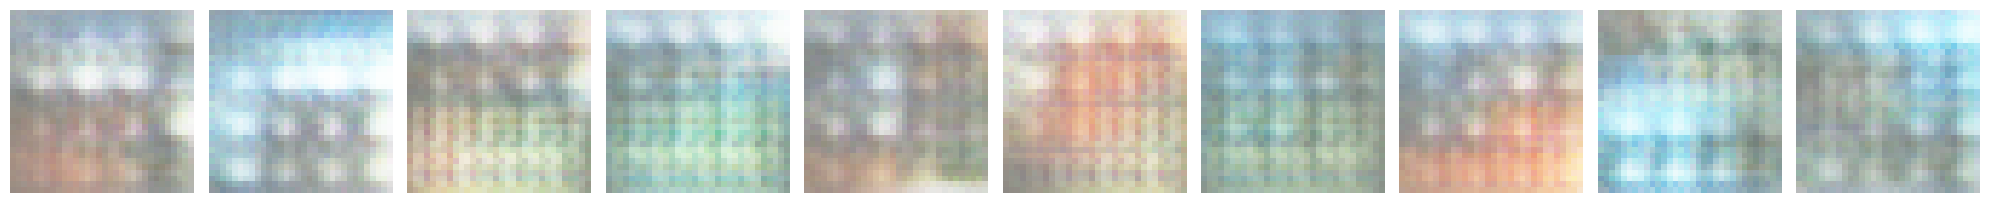

In [59]:
train_model(epochs, batch_size)